In [19]:
%matplotlib inline
import numpy as np

from scipy.io import loadmat 
import mne, glob 

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS
from sklearn.svm import LinearSVC

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)
from mne import io, pick_types, read_events, Epochs, EvokedArray, create_info
from mne.preprocessing import Xdawn
from mne import combine_evoked
from mne.channels import read_layout


In [20]:
# Load raw data

raw = mne.io.read_raw_brainvision('/Volumes/LaCie/AR_mvpa/MNE/feedback/AR_001_rFB_AR.vhdr', preload=True, verbose=False)
raw2 = mne.io.read_raw_brainvision('/Volumes/LaCie/AR_mvpa/MNE/feedback/AR_009_rFB_AR.vhdr', preload=True, verbose=False)
raw3 = mne.io.read_raw_brainvision('/Volumes/LaCie/AR_mvpa/MNE/feedback/AR_003_rFB_AR.vhdr', preload=True, verbose=False)
raw4 = mne.io.read_raw_brainvision('/Volumes/LaCie/AR_mvpa/MNE/feedback/AR_004_rFB_AR.vhdr', preload=True, verbose=False)

# Set montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, verbose=False)
raw2.set_montage(montage, verbose=False)
raw3.set_montage(montage, verbose=False)
raw4.set_montage(montage, verbose=False)



<RawBrainVision | AR_004_rFB_AR.txt, 13 x 995000 (995.0 s), ~98.7 MB, data loaded>

In [21]:


# Construct epochs

events,event_dict = mne.events_from_annotations(raw, verbose=False)

events2,event_dict2 = mne.events_from_annotations(raw2, verbose=False)


events3,event_dict3 = mne.events_from_annotations(raw3, verbose=False)


events4,event_dict4 = mne.events_from_annotations(raw4, verbose=False)




In [22]:
print(events2)

[[     0      0  99999]
 [  2493      0     15]
 [  2500      0  10005]
 ...
 [997500      0      8]
 [997500      0  10005]
 [997694      0     15]]


In [23]:

# 6 left reward
# 7 right reward
# 8 left noreward
# 9 right noreward

event_id = {'Left Reward': 6, 'Right Reward': 7,'Left Noreward': 8, 'Right Noreward': 9 }  # just use two


###BINARY CLASSIFICATION 

#event_id = {'Left Reward': 6, 'Right Reward': 7,'Left Noreward': 8, 'Right Noreward': 9 }  # just use two

## SUB1

#Reward NoReward 

eventsRNR=mne.event.merge_events(events, [6,7],1, replace_events=True)
eventsRNR=mne.event.merge_events(eventsRNR, [8,9],2, replace_events=True)


event_idRNR = {'Reward': 1,'Noreward': 2}  # just use two


## SUB2

#Reward NoReward 

eventsRNR2=mne.event.merge_events(events2, [6,7],1, replace_events=True)
eventsRNR2=mne.event.merge_events(eventsRNR2, [8,9],2, replace_events=True)


event_idRNR2 = {'Reward': 1,'Noreward': 2}  # just use two


#Reward NoReward 

eventsRNR3=mne.event.merge_events(events3, [6,7],1, replace_events=True)
eventsRNR3=mne.event.merge_events(eventsRNR3, [8,9],2, replace_events=True)


event_idRNR3 = {'Reward': 1,'Noreward': 2}  # just use two


#Reward NoReward 

eventsRNR4=mne.event.merge_events(events4, [6,7],1, replace_events=True)
eventsRNR4=mne.event.merge_events(eventsRNR4, [8,9],2, replace_events=True)


event_idRNR4 = {'Reward': 1,'Noreward': 2}  # just use two




## REWARD vs NOREWARD CONDITIONS ##

In [24]:
## CREATE EPOCHS FROM RAW EEG DATA SUB 1-4

#event_id = {'Left Reward': 6, 'Right Reward': 7,'Left Noreward': 8, 'Right Noreward': 9 }  # just use two
# WINDOW tmin=0.1, tmax=0.6, 100ms-600ms AFTER FEEDBACK 

# Setup for reading the raw data

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

reject_criteria = dict(eeg=150e-6)      # 150 µV

# Read epochs
epochs = mne.Epochs(raw, events=eventsRNR, event_id=event_idRNR, tmin=-0.1, tmax=0.6,                     
                    picks = picks,
                    reject=reject_criteria, 
                    proj=True, 
                    baseline=None, 
                    preload=True,
                    verbose='error')


# Read epochs
epochs2 =mne.Epochs(raw2, events=eventsRNR2, event_id=event_idRNR2, tmin=-0.1, tmax=0.6,                         
                    picks = picks,
                    reject=reject_criteria, 
                    proj=True, 
                    baseline=None, 
                    preload=True,
                    verbose='error')


# Read epochs
epochs3 = mne.Epochs(raw3, events=eventsRNR3, event_id=event_idRNR3, tmin=-0.1, tmax=0.6,                         
                    picks = picks,
                    reject=reject_criteria, 
                    proj=True, 
                    baseline=None, 
                    preload=True,
                    verbose='error')


# Read epochs
epochs4 = mne.Epochs(raw4, events=eventsRNR4, event_id=event_idRNR4, tmin=-0.1, tmax=0.6,                        
                    picks = picks,
                    reject=reject_criteria, 
                    proj=True, 
                    baseline=None, 
                    preload=True,
                    verbose='error')




### REWARD CLASSIFICATION ###

Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance 

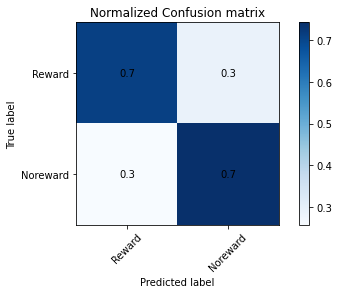

In [31]:
from sklearn.svm import LinearSVC
## XDAWN DECODE LSVM REG SUBJECT 1 
n_filter = 3 # num of components 

# Create classification pipeline 

#SVM
clf = make_pipeline(Xdawn(n_components=n_filter),
                    Vectorizer(),
                    MinMaxScaler(),
                    LinearSVC(C=1,max_iter=10000))




# Get the labels
labels = epochs.events[:, -1]

# Cross validator
cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)

# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv.split(epochs, labels):
    clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])

# Classification report
target_names = ['Reward','Noreward']

report = classification_report(labels, preds, target_names=target_names)
print(report)

# Normalized confusion matrix
cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(1)
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(title='Normalized Confusion matrix')
fig.colorbar(im)
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
fig.tight_layout()
ax.set(ylabel='True label', xlabel='Predicted label')

for (i, j), z in np.ndenumerate(cm_normalized):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

    
plt.savefig('SUB1_LSVC_CLASS.pdf')

Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance 

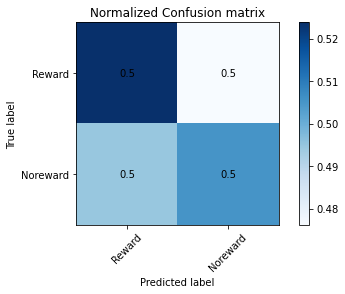

In [26]:
##subject 2

#event_id = {'Left Reward': 6, 'Right Reward': 7,'Left Noreward': 8, 'Right Noreward': 9 }  # just use two



# Get the labels
labels2 = epochs2.events[:, -1]

# Cross validator
cv2 = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)

# Do cross-validation
preds2 = np.empty(len(labels2))
for train, test in cv2.split(epochs2, labels2):
    clf.fit(epochs2[train], labels2[train])
    preds2[test] = clf.predict(epochs2[test])

# Classification report
target_names = ['Reward','Noreward']
report2 = classification_report(labels2, preds2, target_names=target_names)
print(report2)

# Normalized confusion matrix
cm2 = confusion_matrix(labels2, preds2)
cm_normalized2 = cm2.astype(float) / cm2.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(1)
im = ax.imshow(cm_normalized2, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(title='Normalized Confusion matrix')
fig.colorbar(im)
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
fig.tight_layout()
ax.set(ylabel='True label', xlabel='Predicted label')
for (i, j), z in np.ndenumerate(cm_normalized2):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
plt.savefig('SUB2_LSVC_CLASS.pdf')

Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance 

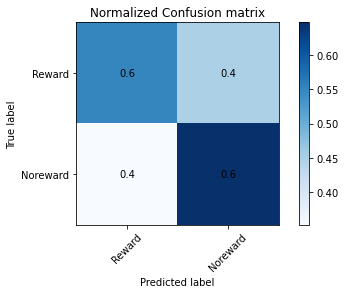

In [28]:
##subject 3

#event_id = {'Left Reward': 6, 'Right Reward': 7,'Left Noreward': 8, 'Right Noreward': 9 }  # just use two


# Get the labels
labels3 = epochs3.events[:, -1]

# Cross validator
cv3 = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)

# Do cross-validation
preds3 = np.empty(len(labels3))
for train, test in cv3.split(epochs3, labels3):
    clf.fit(epochs3[train], labels3[train])
    preds3[test] = clf.predict(epochs3[test])

# Classification report
target_names = ['Reward','Noreward']
report3 = classification_report(labels3, preds3, target_names=target_names)
print(report3)

# Normalized confusion matrix
cm3 = confusion_matrix(labels3, preds3)
cm_normalized3 = cm3.astype(float) / cm3.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(1)
im = ax.imshow(cm_normalized3, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(title='Normalized Confusion matrix')
fig.colorbar(im)
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
fig.tight_layout()
ax.set(ylabel='True label', xlabel='Predicted label')
for (i, j), z in np.ndenumerate(cm_normalized3):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
plt.savefig('SUB3_LSVC_CLASS.pdf')

Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 13 from info
Reducing data rank from 13 -> 13
Estimating covariance 

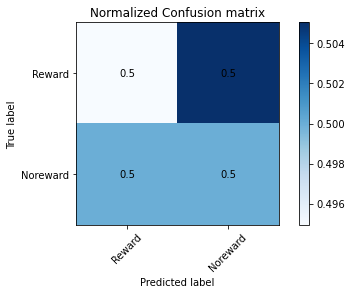

In [29]:
##subject 4

#event_id = {'Left Reward': 6, 'Right Reward': 7,'Left Noreward': 8, 'Right Noreward': 9 }  # just use two


# Get the labels
labels4 = epochs4.events[:, -1]

# Cross validator
cv4 = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)

# Do cross-validation
preds4 = np.empty(len(labels4))
for train, test in cv4.split(epochs4, labels4):
    clf.fit(epochs4[train], labels4[train])
    preds4[test] = clf.predict(epochs4[test])

# Classification report
target_names = ['Reward','Noreward']
report4 = classification_report(labels4, preds4, target_names=target_names)
print(report4)

# Normalized confusion matrix
cm4 = confusion_matrix(labels4, preds4)
cm_normalized4 = cm4.astype(float) / cm4.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(1)
im = ax.imshow(cm_normalized4, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(title='Normalized Confusion matrix')
fig.colorbar(im)
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
fig.tight_layout()
ax.set(ylabel='True label', xlabel='Predicted label')
for (i, j), z in np.ndenumerate(cm_normalized4):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.savefig('SUB4_LSVC_CLASS.pdf')

## REWARDS Spatio-temporal DECODE

In [7]:


# create classification matrix for SUB 1-43

X = epochs.get_data()  # EEG signals: n_epochs, n_channels, n_times
y = epochs.events[:,2]  # target: reward vs noreward

labels = epochs.events[:, -1]
eeg_data = epochs.get_data().reshape(len(labels), -1)


X2 = epochs2.get_data()  # EEG signals: n_epochs, n_channels, n_times
y2 = epochs2.events[:,2]  # target: reward vs noreward

labels2 = epochs2.events[:, -1]
eeg_data2 = epochs2.get_data().reshape(len(labels2), -1)


X3= epochs3.get_data()  # EEG signals: n_epochs, n_channels, n_times
y3 = epochs3.events[:,2]  # target: reward vs noreward
labels3 = epochs3.events[:, -1]
eeg_data3 = epochs3.get_data().reshape(len(labels3), -1)


X4 = epochs4.get_data()  # EEG signals: n_epochs, n_channels, n_times
y4 = epochs4.events[:,2]  # target: reward vs noreward
labels4 = epochs4.events[:, -1]
eeg_data4 = epochs4.get_data().reshape(len(labels4), -1)




In [10]:
# Uses all EEG electrodes and time points as separate classification features, 
#so the resulting filters used are spatio-temporal
clf = make_pipeline(Scaler(epochs.info),
                    Vectorizer(),
                    LinearSVC(C=1,max_iter=10000))

clf2 = make_pipeline(Scaler(epochs2.info),
                    Vectorizer(),
                    LinearSVC(C=1,max_iter=10000))

clf3 = make_pipeline(Scaler(epochs3.info),
                    Vectorizer(),
                    LinearSVC(C=1,max_iter=10000))

clf4 = make_pipeline(Scaler(epochs4.info),
                    Vectorizer(),
                    LinearSVC(C=1,max_iter=10000))

#                    LogisticRegression(solver='lbfgs'))


scores = cross_val_multiscore(clf, X, y, cv=2, n_jobs=1)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score,))


scores2 = cross_val_multiscore(clf2, X2, y2, cv=2, n_jobs=1)

# Mean scores across cross-validation splits
score2 = np.mean(scores2, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score2,))



scores3 = cross_val_multiscore(clf3, X3, y3, cv=2, n_jobs=1)

# Mean scores across cross-validation splits
score3 = np.mean(scores3, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score3,))


scores4 = cross_val_multiscore(clf4, X4, y4, cv=2, n_jobs=1)

# Mean scores across cross-validation splits
score4 = np.mean(scores4, axis=0)
print('Spatio-temporal: %0.1f%%' % (100 * score4,))




print('Spatio-temporal: %0.1f%%' % (100 * score,))
print('Spatio-temporal: %0.1f%%' % (100 * score2,))
print('Spatio-temporal: %0.1f%%' % (100 * score3,))
print('Spatio-temporal: %0.1f%%' % (100 * score4,))



Spatio-temporal: 65.5%
Spatio-temporal: 54.5%
Spatio-temporal: 57.2%
Spatio-temporal: 58.3%
Spatio-temporal: 65.5%
Spatio-temporal: 54.5%
Spatio-temporal: 57.2%
Spatio-temporal: 58.3%


  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


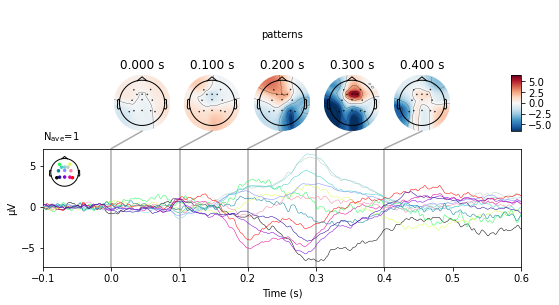

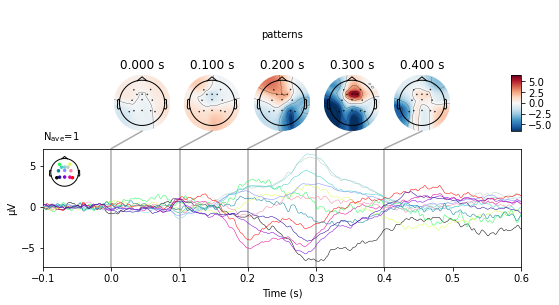

In [11]:
#You can retrieve the spatial filters and spatial patterns if you explicitly use a LinearModel
## SUB 1

clf = make_pipeline(StandardScaler(),
                    LinearModel(LinearSVC(C=1,max_iter=10000)))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                  **joint_kwargs)



  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


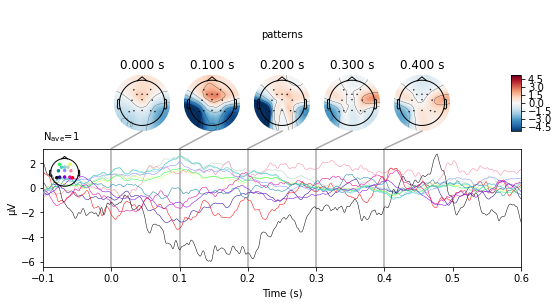

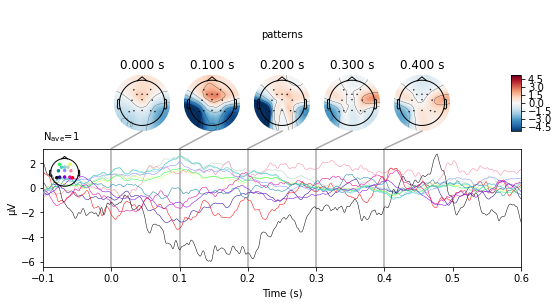

In [15]:
#You can retrieve the spatial filters and spatial patterns if you explicitly use a LinearModel
## SUB 2

time_decod.fit(X2, y2)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs2.info, tmin=epochs2.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                  **joint_kwargs)


In [27]:
#You can retrieve the spatial filters and spatial patterns if you explicitly use a LinearModel
## SUB 3

time_decod.fit(X3, y3)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs3.info, tmin=epochs3.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked.plot_joint(times=np.arange(0.02, .500, .100), title='patterns',
                  **joint_kwargs)



NameError: name 'time_decod' is not defined

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


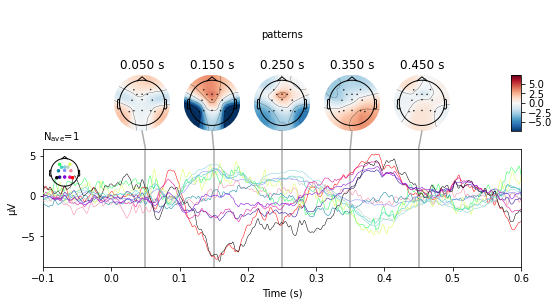

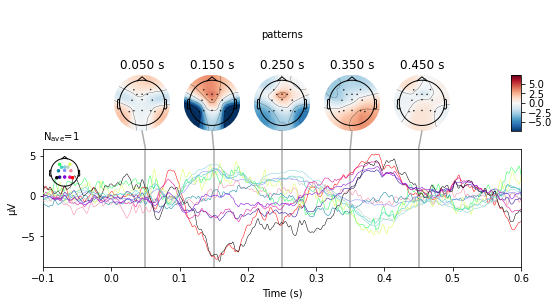

In [17]:
#You can retrieve the spatial filters and spatial patterns if you explicitly use a LinearModel
## SUB 4
time_decod.fit(X4, y4)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs4.info, tmin=epochs4.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked.plot_joint(times=np.arange(0.05, .500, .100), title='patterns',
                  **joint_kwargs)

## REWARDS Spatial DECODE: classification of evoked responses 

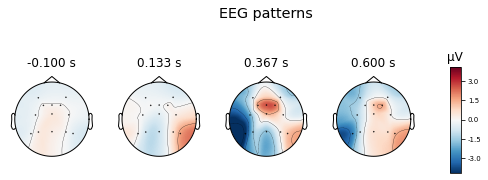

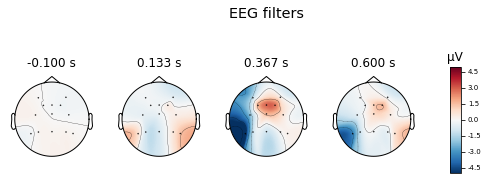

In [12]:
#subject 1

clf =LinearSVC(C=1,max_iter=10000)
scaler = StandardScaler()

# create a linear model with svc
model = LinearModel(clf)

# fit the classifier on eeg data
Xa = scaler.fit_transform(eeg_data)
model.fit(Xa, labels)

# Extract and plot spatial filters and spatial patterns
for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(epochs.ch_names), -1)

    # Plot
    evoked = EvokedArray(coef, epochs.info, tmin=epochs.times[0])
    evoked.plot_topomap(title='EEG %s' % name, time_unit='s')

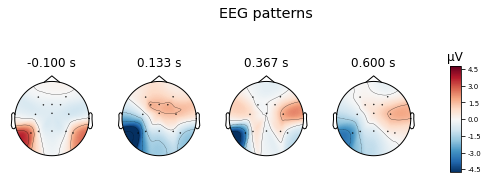

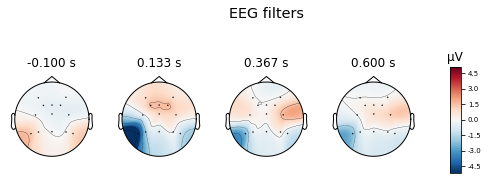

In [13]:
#subject 2

# fit the classifier on EEG data
X2a = scaler.fit_transform(eeg_data2)
model.fit(X2a, labels2)

# Extract and plot spatial filters and spatial patterns
for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(epochs2.ch_names), -1)

    # Plot
    evoked = EvokedArray(coef, epochs2.info, tmin=epochs2.times[0])
    evoked.plot_topomap(title='EEG %s' % name, time_unit='s')

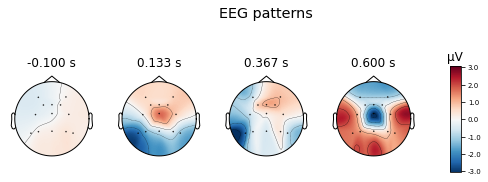

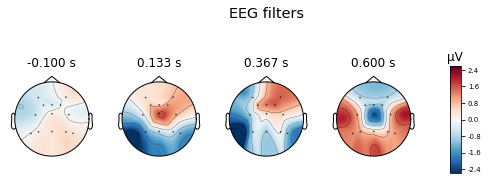

In [14]:
#subject 3

# fit the classifier on EEG data
X3a = scaler.fit_transform(eeg_data3)
model.fit(X3a, labels3)

# Extract and plot spatial filters and spatial patterns
for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(epochs3.ch_names), -1)

    # Plot
    evoked = EvokedArray(coef, epochs3.info, tmin=epochs3.times[0])
    evoked.plot_topomap(title='EEG %s' % name, time_unit='s')

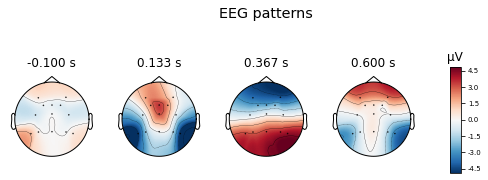

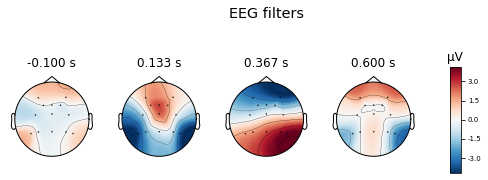

In [15]:
#subject 4

# fit the classifier on EEG data
X4a = scaler.fit_transform(eeg_data4)
model.fit(X4a, labels4)

# Extract and plot spatial filters and spatial patterns
for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(epochs4.ch_names), -1)

    # Plot
    evoked = EvokedArray(coef, epochs4.info, tmin=epochs4.times[0])
    evoked.plot_topomap(title='EEG %s' % name, time_unit='s')

## Decoding over time

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

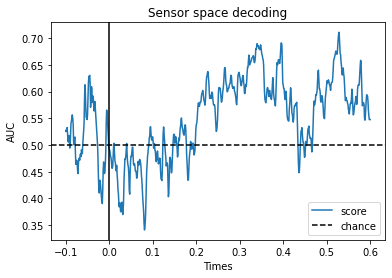

In [48]:
# SUB1
# We will train the classifier on all reward vs noreward trials on EEG

clf = make_pipeline(StandardScaler(),LinearSVC(C=1,max_iter=10000))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc', verbose=True)
# here we use cv=3 just for speed
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')

plt.savefig('SUB1_LSVC_TEMP.pdf')

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

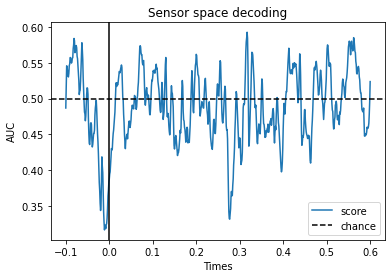

In [49]:
# SUB2
# We will train the classifier on all reward vs noreward trials on EEG

scores = cross_val_multiscore(time_decod, X2, y2, cv=3, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs2.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.savefig('SUB2_LSVC_TEMP.pdf')

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

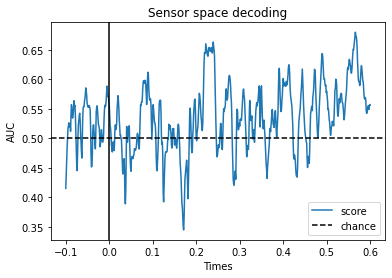

In [50]:
# SUB3
# We will train the classifier on all reward vs noreward trials on EEG

scores = cross_val_multiscore(time_decod, X3, y3, cv=3, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs3.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.savefig('SUB3_LSVC_TEMP.pdf')

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/701 [00:00<?,       ?it/s]

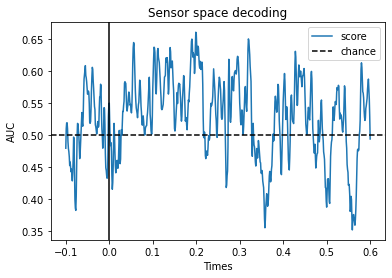

In [51]:
# SUB4
# We will train the classifier on all reward vs noreward trials on EEG
# here we use cv=3 just for speed
scores = cross_val_multiscore(time_decod, X4, y4, cv=3, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs4.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.savefig('SUB4_LSVC_TEMP.pdf')

In [ ]:
##overview of variables created
#variables = %who_ls
#for v in variables:
 #   print(v, type(eval(v)).__name__, str(eval(v)))

### ERP ###

In [48]:
# #############################################################################
# # Set parameters and read data

epochs_train = epochs.copy().crop(tmin=0, tmax=.4)
labels = epochs.events[:, -1] - 2

Computing rank from data with rank=None
    Using tolerance 8.4e-06 (2.2e-16 eps * 13 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 13
    MAG: rank 13 computed from 13 data channels with 0 projectors
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-06 (2.2e-16 eps * 13 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 13
    MAG: rank 13 computed from 13 data channels with 0 projectors
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-06 (2.2e-16 eps * 13 dim * 2.8e+09  max singular value)
    Estimated rank (mag): 13
    MAG: rank 13 computed from 13 data channels with 0 projectors
Reducing data rank from 13 -> 13
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.4e-06 (2.2e-16 eps * 13 dim * 2.6e+09  max singular value)


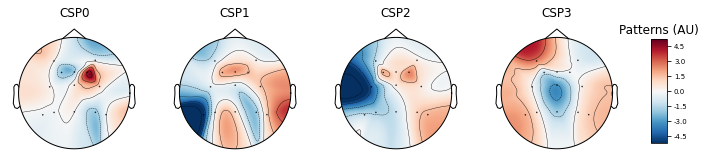

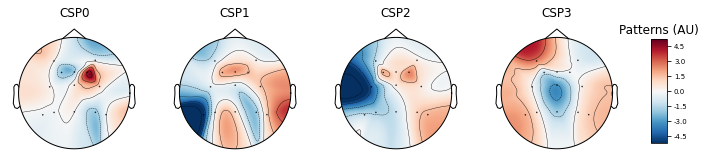

In [53]:
epochs_train = epochs.copy()
labels = epochs.events[:, -1] - 2


# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.2, random_state=None)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

In [36]:
clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
time_gen = GeneralizingEstimator(clf, scoring='roc_auc', n_jobs=1,
                                 verbose=True)

# Fit classifiers on the epochs where the stimulus was presented.
# Note that the experimental condition y indicates reward or noreward

time_gen.fit(X,y)
scores = time_gen.score(X,y)

  0%|          | Fitting GeneralizingEstimator : 0/701 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/491401 [00:00<?,       ?it/s]

In [ ]:
fig, ax = plt.subplots(1)
im = ax.matshow(scores, vmin=0, vmax=1., cmap='RdBu_r', origin='lower',
                extent=epochs.times[[0, -1, 0, -1]])
ax.axhline(0., color='k')
ax.axvline(0., color='k')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Generalization across time and condition')
plt.colorbar(im, ax=ax)
plt.show()

In [10]:
print(X.shape)

(200, 13, 701)
